# Downloads and model classes


In [1]:
!pip install svgwrite
import numpy as np
import tensorflow as tf
import sys
import matplotlib.pyplot as plt

     |████████████████████████████████| 66 kB 3.0 MB/s 


In [2]:
def positional_encoding(max_seq_len, dm):
    """
    Calculates the positional encoding for a transformer
    max_seq_len: integer representing the maximum sequence length
    dm: integer representing the model depth
    Returns: numpy.ndarray of shape (max_seq_len, dm) containing the positional
             encoding vectors
    """
    PE = np.zeros((max_seq_len, dm))
    for row in range(max_seq_len):
        for col in range(0, dm, 2):
            PE[row, col] = np.sin(row / (10000 ** (col / dm)))
            PE[row, col + 1] = np.cos(row / (10000 ** (col / dm)))
    return PE


def sdp_attention(Q, K, V, mask=None):
    """
    Q: tensor with shape (..., seq_len_q, dk) containing the query matrix
    K: tensor with shape (..., seq_len_v, dk) containing the key matrix
    V: tensor with shape (..., seq_len_v, dv) containing the value matrix
    mask: tensor that can be broadcast into (..., seq_len_q, seq_len_v)
          containing the optional maask, or defaulted to None
    The Preceding dimensions of Q, K, and V are the same
    Returns: output, weights
             output: tensor with shape (..., seq_len_q, dv) containing the dot
                     product attention
             weights: tensor with shape (..., seq_len_q, seq_len_v) containing
                      the attention weights
    """
    # Matmul Q and K
    QK = tf.matmul(Q, K, transpose_b=True)

    # Scale the dot product
    dk = tf.cast(tf.shape(K)[-1], tf.float32)
    scaled = QK / tf.math.sqrt(dk)

    # Add mask if not None
    if mask is not None:
        scaled += mask * -1e9

    # Pass scaled attention through softmax activation
    weights = tf.nn.softmax(scaled, axis=-1)

    # Matmul by value matrix for output
    output = tf.matmul(weights, V)

    return output, weights


class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Class to perform multi head attention
    """
    def __init__(self, dm, h):
        """
        dm: integer representing the model dimensionality
        h: integer representing the number of heads
        dm is divisible by h
        """
        super(MultiHeadAttention, self).__init__()
        self.h = h
        self.dm = dm
        self.depth = dm // self.h
        self.Wq = tf.keras.layers.Dense(dm)
        self.Wk = tf.keras.layers.Dense(dm)
        self.Wv = tf.keras.layers.Dense(dm)
        self.linear = tf.keras.layers.Dense(dm)

    def split_heads(self, x, batch_size):
        """
        Splits the last dimension of tensor x into (h, depth)
        Transpose the result such that the shape is
        (batch_size, h, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.h, self.depth))
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        return x

    def call(self, Q, K, V, mask):
        """
        Q: tensor with shape (..., seq_len_q, dk) containing the query matrix
        K: tensor with shape (..., seq_len_v, dk) containing the key matrix
        V: tensor with shape (..., seq_len_v, dv) containing the value matrix
        mask: always None
        The Preceding dimensions of Q, K, and V are the same
        Returns: output, weights
                 output: tensor with shape (..., seq_len_q, dv) containing the
                         dot product attention
                 weights: tensor with shape (..., seq_len_q, seq_len_v)
                          containing the attention weights
        """
        batch_size = tf.shape(Q)[0]

        # Generate query, key, and value matrices
        Q = self.Wq(Q)
        K = self.Wk(K)
        V = self.Wv(V)

        # Split between heads
        Q = self.split_heads(Q, batch_size)
        K = self.split_heads(K, batch_size)
        V = self.split_heads(V, batch_size)

        # Scaled Dot Product Attention
        attention, weights = sdp_attention(Q, K, V, mask)

        # Refit to pass through linear layer
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        attention = tf.reshape(attention, (batch_size, -1, self.dm))
        output = self.linear(attention)

        return output, weights


class EncoderBlock(tf.keras.layers.Layer):
    """
    Class representation of an encoder block for a transformer
    """
    def __init__(self, dm, h, hidden, drop_rate=0.1):
        """
        dm: Dimensionality of the model
        h: Number of heads
        hidden: Number of hidden units in the fully connected layer
        drop_rate: Dropout rate
        """
        super(EncoderBlock, self).__init__()
        self.mha = MultiHeadAttention(dm, h)
        self.dense_hidden = tf.keras.layers.Dense(
            units=hidden,
            activation='relu'
        )
        self.dense_output = tf.keras.layers.Dense(dm)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(drop_rate)
        self.dropout2 = tf.keras.layers.Dropout(drop_rate)

    def call(self, x, training, mask=None):
        """
        x: tensor of shape (batch, input_seq_len, dm) containing the input to
           the encoder block
        training: boolean to determine if the model is training
        mask: the mask to be applied for multi head attention
        Returns: tensor of the shape (batch, input_seq_len, dm) containing the
                 block's output
        """
        # Pass through multi head attention and dropout layers
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)

        # Add and normalize
        out1 = self.layernorm1(x + attn_output)

        # Feed through dense layers and dropout layer
        dense_output = self.dense_hidden(out1)
        dense_output = self.dense_output(dense_output)
        dense_output = self.dropout2(dense_output, training=training)

        # Add and normalize
        out2 = self.layernorm2(out1 + dense_output)

        return out2


class DecoderBlock(tf.keras.layers.Layer):
    """
    Class representation of a decoder block for a transformer
    """
    def __init__(self, dm, h, hidden, drop_rate=0.1):
        """
        dm: Dimensionality of the model
        h: Number of heads
        hidden: Number of hidden units in the fully connected layer
        drop_rate: Dropout rate
        """
        super(DecoderBlock, self).__init__()
        self.mha1 = MultiHeadAttention(dm, h)
        self.mha2 = MultiHeadAttention(dm, h)
        self.dense_hidden = tf.keras.layers.Dense(
            units=hidden,
            activation='relu'
        )
        self.dense_output = tf.keras.layers.Dense(units=dm)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(drop_rate)
        self.dropout2 = tf.keras.layers.Dropout(drop_rate)
        self.dropout3 = tf.keras.layers.Dropout(drop_rate)

    def call(self, x, encoder_output, training, look_ahead_mask, padding_mask):
        """
        x: tensor of shape (batch, target_seq_len, dm)containing the input to
           the decoder block
        encoder_output: tensor of shape (batch, input_seq_len, dm)containing
                        the output of the encoder
        training: boolean to determine if the model is training
        look_ahead_mask: mask to be applied to the first multi head attention
                         layer
        padding_mask: mask to be applied to the second multi head attention
                      layer
        Returns: tensor of shape (batch, target_seq_len, dm) containing the
                 block's output
        """
        # Pass through first round of MHA and dropout layers
        attn_out, _ = self.mha1(x, x, x, look_ahead_mask)
        attn_out = self.dropout1(attn_out, training=training)

        # Add and normalize
        out1 = self.layernorm1(x + attn_out)

        # Pass trough second round of MHA and dropout layers
        attn_out, _ = self.mha2(
            out1,
            encoder_output,
            encoder_output,
            padding_mask
        )
        attn_out = self.dropout2(attn_out, training=training)

        # Add and normalize
        out2 = self.layernorm2(out1 + attn_out)

        # Pass through dense layers and dropout layer
        dense_output = self.dense_hidden(out2)
        dense_output = self.dense_output(dense_output)
        dense_output = self.dropout3(dense_output, training=training)

        # Add and normalize
        out3 = self.layernorm3(out2 + dense_output)

        return out3


class Encoder(tf.keras.layers.Layer):
    """
    Class representation of an encoder for a transformer
    """
    def __init__(self, N, dm, h, hidden, max_seq_len,
                 drop_rate=0.1):
        """
        N: Number of blocks in the encoder
        dm: Dimensionality of the model
        h: Number of heads
        hidden: Number of hidden units in the fully connected layer
        input_vocab: Size of the input vocabulary
        max_seq_len: Maximum sequence length possible
        drop_rate: Dropout rate
        """
        super(Encoder, self).__init__()
        self.N = N
        self.dm = dm
        self.projecting = tf.keras.layers.Dense(dm)
        # self.embedding = tf.keras.layers.Embedding(input_vocab, dm)
        self.positional_encoding = positional_encoding(max_seq_len, dm)
        self.blocks = []
        for n in range(N):
            self.blocks.append(EncoderBlock(dm, h, hidden, drop_rate))
        self.dropout = tf.keras.layers.Dropout(drop_rate)

    def call(self, x, training, mask):
        """
        x: tensor of shape (batch, input_seq_len, dm) containing the input to
           the encoder
        training: boolean to determine if the model is training
        mask: mask to the applied for multi head attention
        Returns: tensor of shape (batch, input_seq_len, dm) containing the
                 encoder output
        """
        seq_len = int(x.shape[1])

        # Pass input through embedding layer
        # x = self.embedding(x)

        # Pass input through projecting layer
        x = self.projecting(x)

        # Add positional encoding, pass through dropout layer
        x *= tf.math.sqrt(tf.cast(self.dm, 'float32'))
        x += self.positional_encoding[:seq_len]
        x = self.dropout(x, training=training)

        # Pass through each encoding block
        for block in self.blocks:
            x = block(x, training, mask)

        return x


class Decoder(tf.keras.layers.Layer):
    """
    Class representation of a decoder for a transformer
    """
    def __init__(self, N, dm, h, hidden, max_seq_len,
                 drop_rate=0.1):
        """
        dm - the dimensionality of the model
        h - the number of heads
        hidden - the number of hidden units in the fully connected layer
        target_vocab - deprecated
        max_seq_len - the maximum sequence length possible
        drop_rate - the dropout rate
        """
        super(Decoder, self).__init__()
        self.N = N
        self.dm = dm
        # self.embedding = tf.keras.layers.Embedding(target_vocab, dm)
        self.projecting = tf.keras.layers.Dense(dm)
        self.positional_encoding = positional_encoding(max_seq_len, dm)
        self.blocks = []
        for n in range(N):
            self.blocks.append(DecoderBlock(dm, h, hidden, drop_rate))
        self.dropout = tf.keras.layers.Dropout(drop_rate)

    def call(self, x, encoder_output, training, look_ahead_mask, padding_mask):
        """
        x - a tensor of shape (batch, target_seq_len, dm) containing the input
            to the decoder
        encoder_output - a tensor of shape (batch, input_seq_len, dm)
            containing the output of the encoder
        training - a boolean to determine if the model is training
        look_ahead_mask - the mask to be applied to the first multi head
            attention layer
        padding_mask - the mask to be applied to the second multi head
            attention layer
        Returns: a tensor of shape (batch, target_seq_len, dm) containing the
            decoder output
        """
        seq_len = int(x.shape[1])

        # Pass through embedding layer
        # x = self.embedding(x)

        # Replace embedding with projecting
        x = self.projecting(x)

        # Add positional encoding and pass through dropout layer
        x *= tf.math.sqrt(tf.cast(self.dm, 'float32'))
        x += self.positional_encoding[:seq_len]
        x = self.dropout(x, training=training)

        # Pass through each decoder block
        for block in self.blocks:
            x = block(
                x,
                encoder_output,
                training,
                look_ahead_mask,
                padding_mask
            )

        return x


class Transformer(tf.keras.Model):
    """
    Class representation of a transformer network
    """
    def __init__(self, N, dm, h, hidden,
                 max_seq_input, max_seq_target, drop_rate=0.1):
        """
        N - the number of blocks in the encoder and decoder
        dm - the dimensionality of the model
        h - the number of heads
        hidden - the number of hidden units in the fully connected layers
        input_vocab - deprecated
        target_vocab - deprecated
        max_seq_input - the maximum sequence length possible for the input
        max_seq_target - the maximum sequence length possible for the target
        drop_rate - the dropout rate
        """
        super(Transformer, self).__init__()
        self.encoder = Encoder(
            N,
            dm,
            h,
            hidden,
            max_seq_input,
            drop_rate
        )
        self.decoder = Decoder(
            N,
            dm,
            h,
            hidden,
            max_seq_target,
            drop_rate
        )
        self.linear = tf.keras.layers.Dense(units=5)

    def call(self, inputs, target, training, encoder_mask, look_ahead_mask,
             decoder_mask):
        """
        inputs - a tensor of shape (batch, input_seq_len)containing the inputs
        target - a tensor of shape (batch, target_seq_len)containing the target
        training - a boolean to determine if the model is training
        encoder_mask - the padding mask to be applied to the encoder
        look_ahead_mask - the look ahead mask to be applied to the decoder
        decoder_mask - the padding mask to be applied to the decoder
        Returns: a tensor of shape (batch, target_seq_len, target_vocab)
            containing the transformer output
        """
        encoder_output = self.encoder(inputs, training, encoder_mask)
        decoder_output = self.decoder(
            target,
            encoder_output,
            training,
            look_ahead_mask,
            decoder_mask
        )
        output = self.linear(decoder_output)

        return output

# dataset class and masking f'n

In [3]:
# Function from utils.py for sketch-rnn in the Magenta github repository
# at https://github.com/magenta/magenta/tree/main/magenta/models/sketch_rnn
def to_big_strokes(stroke, max_len=250):
  """Converts from stroke-3 to stroke-5 format and pads to given length."""
  # (But does not insert special start token).

  result = np.zeros((max_len, 5), dtype=float)
  l = len(stroke)
  assert l <= max_len
  result[0:l, 0:2] = stroke[:, 0:2]
  result[0:l, 3] = stroke[:, 2]
  result[0:l, 2] = 1 - result[0:l, 3]
  result[l:, 4] = 1
  return result

# Tokenizing isn't being used anymore but these functions are being kept
# until we're absolutely certain we don't need them

def strokes_to_tokens(strokes):
    """
    strokes is a 2d numpy array of stroke-5 vectors to be converted into tokens
    Returns a list of the tokenized vectors
    """
    tokens = []
    for stroke in strokes:
        token = (stroke[0] + 255) * 511
        token += (stroke[1] + 255)
        token += np.sum(np.array([100, 500000, 1000000]) * stroke[2:])
        tokens.append(token)
    return np.asarray(tokens)

def tokens_to_strokes(tokens):
    """
    tokens is a 1d numpy array of stroke tokens to be converted into strokes
    Returns a list of the strokes
    """
    strokes = []
    for token in tokens:
        stroke = [0] * 5
        if token // 1000000 == 1:
            stroke[4] = 1
            token -= 1000000
        elif token // 500000 == 1:
            stroke[3] = 1
            token -= 500000
        else:
            stroke[2] = 1
            token -= 100
        stroke[0] = token // 511 - 255
        stroke[1] = token % 511 - 255
        strokes.append(stroke)
    return np.asarray(strokes)


def clean(data, max_length=100):
    """
    Data is a np 3d array of samples in stroke-3 format
    Removes all samples with length > max_length
    Converts to stroke-5 and pads to max_length
    Tokenizes stroke-5 vectors
    Scales offsets down by a factor of eight and rounds
    Returns tokenized dataset as a np 2d array
    """
    dataset = []
    for sample in data:
        if len(sample) <= max_length:
            sample = to_big_strokes(sample, max_length)
            dataset.append(sample)
    dataset = np.asarray(dataset)
    #dataset[:, :, :2] /= 8
    dataset = np.round(dataset)
    return dataset

class Dataset:
    """ Document later """

    def __init__(self, filepath, batch_size=32, max_length=250):
        """ Init """
        data = np.load(
            filepath,
            encoding='latin1',
            allow_pickle=True
        )

        # Clean up dataset, removing samples over max_length
        # and tokenizing
        self.train = clean(data['train'])
        self.valid = clean(data['valid'])
        self.test = clean(data['test'])

        # Convert to tensorflow datasets for training
        self.train = tf.convert_to_tensor(self.train)
        self.train = tf.data.Dataset.from_tensor_slices(list(self.train))
        self.valid = tf.convert_to_tensor(self.valid)
        self.valid = tf.data.Dataset.from_tensor_slices(list(self.valid))
        self.test = tf.convert_to_tensor(self.test)
        self.test = tf.data.Dataset.from_tensor_slices(list(self.test))

        # Shuffle and batch train and valid sets
        self.train = self.train.shuffle(max_length)
        self.valid = self.valid.shuffle(max_length)
        self.train = self.train.batch(batch_size)
        self.valid = self.valid.batch(batch_size)


In [4]:
def create_masks(inputs, target):
    """
    Creates all masks for training/validation
    inputs: tf.Tensor of shape (batch_size, seq_len_in) that contains the input
        sentence
    target: tf.Tensor of shape (batch_size, seq_len_out) that contains the
        target sentence
    Returns: encoder_mask, combined_mask, decoder_mask
        encoder_mask: tf.Tensor padding mask of shape
            (batch_size, 1, 1, seq_len_in) to be applied to the encoder
        combined_mask: tf.Tensor of shape
            (batch_size, 1, seq_len_out, seq_len_out) used in the first
            attention block in the decoder to pad and mask future tokens in the
            input received by the decoder. It takes the maximum between a
            look ahead mask and the decoder target padding mask.
        decoder_mask: tf.Tensor padding mask of shape
            (batch_size, 1, 1, seq_len_in) used in the second attention block
            in the decoder.
    """
    inputs = tf.reduce_sum(inputs, axis=-1)
    target = tf.reduce_sum(target, axis=-1)

    encoder_mask = tf.cast(tf.math.equal(inputs, 1), tf.float32)
    encoder_mask = encoder_mask[:, tf.newaxis, tf.newaxis, :]
    decoder_mask = tf.identity(encoder_mask)


    decoder_target_mask = tf.cast(tf.math.equal(target, 1), tf.float32)
    decoder_target_mask = decoder_target_mask[:, tf.newaxis, tf.newaxis, :]

    target_seq_len = tf.shape(target)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(
        tf.ones((target_seq_len, target_seq_len)), -1, 0
    )

    combined_mask = tf.maximum(decoder_target_mask, look_ahead_mask)

    return encoder_mask, combined_mask, decoder_mask

# Training

In [21]:
def train_transformer(N, dm, h, hidden, max_len, batch_size, epochs):
    """ creates and trains a transformer model for machine translation
          of portuguese to English
        N: number of encoder and decoder blocks
        dm: dimensionality of the model
        h: number of heads
        hidden: number of hidden units in fc layers
        max_len: max tokens per sequence
        batch_size: batch size for training
        epochs: number of epochs
        adam opt (beta1=0.9, beta2=0.98, epsilon=1e-9)
        also special learning rat eequation
        sparse categorical crossentropy
        Returns: the trained model
    """
    # create dataset
    data = Dataset('cat.npz', batch_size=batch_size)
    
    # Create model
    transformer = Transformer(
        N,
        dm,
        h,
        hidden,
        max_len,
        max_len
    )

    # create list to track loss history
    loss_history = []
    
    # create loss objects
    mse_loss = tf.keras.losses.MeanSquaredError()
    ce_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

    def create_mask(batch_size, seq_len):
        """
        Creates the look mask for attention in the decoder
        seq_len: Length of the sequence for which to make the mask
        """
        
        mask = 1 - tf.linalg.band_part(tf.ones((1, 1, seq_len, seq_len)), -1, 0)
        return mask


    def loss_function(real, pred):
        """ custom loss function for transformer 
            real are real values of output
            pred: output of the model
        """
        #labels = create_labels(real)
        #for n in range(len(labels)):
        #    labels[n] = tf.cast(labels[n], dtype=pred[0].dtype)

        #x_loss = tf.reduce_sum(loss_(labels[0], pred[0])) / tf.reduce_sum(labels[0])
        #y_loss = tf.reduce_sum(loss_(labels[1], pred[1])) / tf.reduce_sum(labels[1])
        #pen_loss = tf.reduce_sum(loss_(labels[2], pred[2])) / tf.reduce_sum(labels[2])

        #loss = x_loss + y_loss + pen_loss

        #mse_loss = loss_(real[:, :, :2], pred[:, :, :2])
        #cce_loss = ce_loss(real[:, :, 2:], pred[:, :, 2:])

        return mse_loss(real, pred)

      # can cast if necessary like so
      # mask = tf.cast(mask, dtype=loss_.dtype)
      # loss_ *= mask
      # do we still need to / by reduced sum
      

    # set some hyper param stuff
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    learning_rate = CustomSchedule(dm)
    # alternative to custom 
    # learning_rate = 0.005
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    
    # train step f'n
    #@tf.function(input_signature=train_step_signature)
    def train_step(inp, tar):
      """ single train step 
          takes in input and a target value
      """
      # get inp/tar in right form
      # i think this is wrong unfortunately
      tar_inp = tar[:, :-1]
      tar_real = tar[:, 1:]
      
      #enc_inp = inp
      enc_inp = inp[:, :20]

      # create masks
      encoder_mask, combined_mask, decoder_mask = create_masks(enc_inp, tar_inp)

      with tf.GradientTape() as tape:
          predictions = transformer(
                enc_inp,
                tar_inp,
                True,
                encoder_mask,
                combined_mask,
                decoder_mask
            )

          # must also take third arg for this loss f'n
          # loss = loss_function(tar_real, predictions)
          loss = loss_function(tar_real, predictions)

      grads = tape.gradient(loss, transformer.trainable_variables)
      optimizer.apply_gradients(
          zip(grads, transformer.trainable_variables))

      train_loss(loss)
      loss_history.append(train_loss.result())

    # then do the training
    for epoch in range(epochs):
        train_loss.reset_states()
        for batch, inp in enumerate(data.train):
            train_step(inp, inp)

            if batch % 50 == 0:
                if batch % 50 == 0:
                    print("Epoch {}, batch {}: Loss: {}".format(
                        epoch + 1,
                        batch,
                        train_loss.result()
                    ))
        print("Epoch {}: loss: {}".format(
            epoch + 1,
            train_loss.result()
        ))
    return transformer, loss_history


class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """ Custom learning rate schedule """
    def __init__(self, d_model, warmup_steps=4000):
        """ Init """
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        """ Call """
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

def retrain(transformer, batch_size, epochs):
    """ continue training a previously trained model """
    # create dataset
    data = Dataset('cat.npz', batch_size=batch_size)

    # create new list to track loss history
    loss_history = []
    
    # create loss objects
    mse_loss = tf.keras.losses.MeanSquaredError()
    ce_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

    def loss_function(real, pred):
        """ custom loss function for transformer 
            real are real values of output
            pred: output of the model
        """
        return mse_loss(real, pred)

    # set some hyper param stuff
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    learning_rate = CustomSchedule(transformer.encoder.dm)
    # alternative to custom 
    # learning_rate = 0.005
    optimizer = tf.keras.optimizers.Adam(learning_rate)

    def train_step(inp, tar):
      """ single train step 
          takes in input and a target value
      """
      # get inp/tar in right form
      # i think this is wrong unfortunately
      tar_inp = tar[:, :-1]
      tar_real = tar[:, 1:]
      
      #enc_inp = inp
      enc_inp = inp[:, :20]

      # create masks
      encoder_mask, combined_mask, decoder_mask = create_masks(enc_inp, tar_inp)

      with tf.GradientTape() as tape:
          predictions = transformer(
                enc_inp,
                tar_inp,
                True,
                encoder_mask,
                combined_mask,
                decoder_mask
            )

          # must also take third arg for this loss f'n
          # loss = loss_function(tar_real, predictions)
          loss = loss_function(tar_real, predictions)

      grads = tape.gradient(loss, transformer.trainable_variables)
      optimizer.apply_gradients(
          zip(grads, transformer.trainable_variables))

      train_loss(loss)
      loss_history.append(train_loss.result())

    # then do the training
    for epoch in range(epochs):
        train_loss.reset_states()
        for batch, inp in enumerate(data.train):
            train_step(inp, inp)

            if batch % 50 == 0:
                if batch % 50 == 0:
                    print("Epoch {}, batch {}: Loss: {}".format(
                        epoch + 1,
                        batch,
                        train_loss.result()
                    ))
        print("Epoch {}: loss: {}".format(
            epoch + 1,
            train_loss.result()
        ))
    return transformer, loss_history

# train testing

In [13]:
model, loss_history = train_transformer(6, 256, 32, 512, 100, 64, 5)

Epoch 1, batch 0: Loss: 482.5292053222656
Epoch 1, batch 50: Loss: 457.73980712890625
Epoch 1, batch 100: Loss: 457.13836669921875
Epoch 1, batch 150: Loss: 448.1417236328125
Epoch 1, batch 200: Loss: 439.9256896972656
Epoch 1, batch 250: Loss: 432.4217224121094
Epoch 1, batch 300: Loss: 427.70806884765625
Epoch 1, batch 350: Loss: 422.7500915527344
Epoch 1, batch 400: Loss: 417.0492858886719
Epoch 1, batch 450: Loss: 413.74169921875
Epoch 1, batch 500: Loss: 409.9502868652344
Epoch 1, batch 550: Loss: 406.8734436035156
Epoch 1, batch 600: Loss: 404.14251708984375
Epoch 1, batch 650: Loss: 401.2210693359375
Epoch 1, batch 700: Loss: 398.7089538574219
Epoch 1, batch 750: Loss: 396.69439697265625
Epoch 1, batch 800: Loss: 395.02105712890625
Epoch 1, batch 850: Loss: 393.0928649902344
Epoch 1, batch 900: Loss: 391.1784362792969
Epoch 1, batch 950: Loss: 390.0386047363281
Epoch 1: loss: 389.060546875
Epoch 2, batch 0: Loss: 350.3294372558594
Epoch 2, batch 50: Loss: 365.2881164550781
Epoch

Epoch 1, batch 0: Loss: 175.93722534179688
Epoch 1, batch 50: Loss: 197.6011962890625
Epoch 1, batch 100: Loss: 197.95230102539062
Epoch 1, batch 150: Loss: 197.2672576904297
Epoch 1, batch 200: Loss: 195.95025634765625
Epoch 1, batch 250: Loss: 194.91566467285156
Epoch 1, batch 300: Loss: 195.669921875
Epoch 1, batch 350: Loss: 195.4561004638672
Epoch 1, batch 400: Loss: 194.24118041992188
Epoch 1, batch 450: Loss: 194.35206604003906
Epoch 1, batch 500: Loss: 194.4602813720703
Epoch 1, batch 550: Loss: 193.95310974121094
Epoch 1, batch 600: Loss: 193.9517364501953
Epoch 1, batch 650: Loss: 193.41334533691406
Epoch 1, batch 700: Loss: 193.0749969482422
Epoch 1, batch 750: Loss: 192.80638122558594
Epoch 1, batch 800: Loss: 193.0418243408203
Epoch 1, batch 850: Loss: 193.0738983154297
Epoch 1, batch 900: Loss: 192.78176879882812
Epoch 1, batch 950: Loss: 192.85968017578125
Epoch 1: loss: 192.77914428710938
Epoch 2, batch 0: Loss: 204.80752563476562
Epoch 2, batch 50: Loss: 194.4602661132

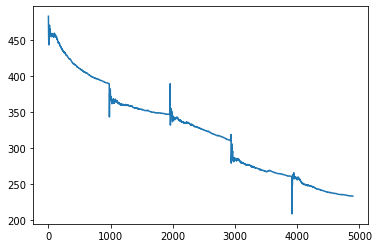

In [23]:
model, loss_history1 = retrain(model, 64, 3)
plt.plot(range(len(loss_history1)), loss_history)
plt.show()

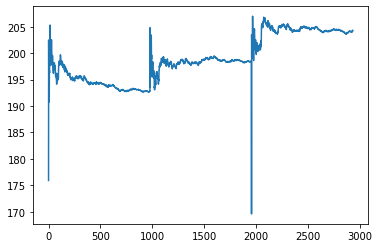

In [27]:
plt.plot(range(len(loss_history1)), loss_history1)
plt.show()
model.save_weights("multihead_weights")
# model.save("multihead_model")

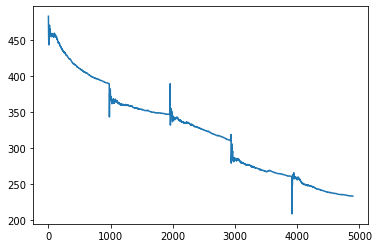

In [14]:
import matplotlib.pyplot as plt

plt.plot(range(len(loss_history)), loss_history)
plt.show()

(1, 100, 5)
True: [-18.   5.   1.   0.   0.]
Pred: [-18.   5.   1.   0.   0.]

True: [-15.  16.   1.   0.   0.]
Pred: [-15.  16.   1.   0.   0.]

True: [-7. 13.  1.  0.  0.]
Pred: [-7. 13.  1.  0.  0.]

True: [-1. 36.  1.  0.  0.]
Pred: [-1. 36.  1.  0.  0.]

True: [ 9. 15.  1.  0.  0.]
Pred: [ 9. 15.  1.  0.  0.]

True: [28. 26.  1.  0.  0.]
Pred: [28. 26.  1.  0.  0.]

True: [13.  4.  1.  0.  0.]
Pred: [13.  4.  1.  0.  0.]

True: [29. -1.  1.  0.  0.]
Pred: [29. -1.  1.  0.  0.]

True: [ 32. -15.   1.   0.   0.]
Pred: [ 32. -15.   1.   0.   0.]

True: [ 24. -22.   1.   0.   0.]
Pred: [ 24. -22.   1.   0.   0.]

True: [ 11. -16.   1.   0.   0.]
Pred: [ 11. -16.   1.   0.   0.]

True: [  3. -10.   1.   0.   0.]
Pred: [  3. -10.   1.   0.   0.]

True: [ -2. -23.   1.   0.   0.]
Pred: [ -2. -23.   1.   0.   0.]

True: [-12. -18.   1.   0.   0.]
Pred: [-12. -18.   1.   0.   0.]

True: [-24. -12.   1.   0.   0.]
Pred: [-24. -12.   1.   0.   0.]

True: [-21.  -3.   1.   0.   0.]
Pred: [-21

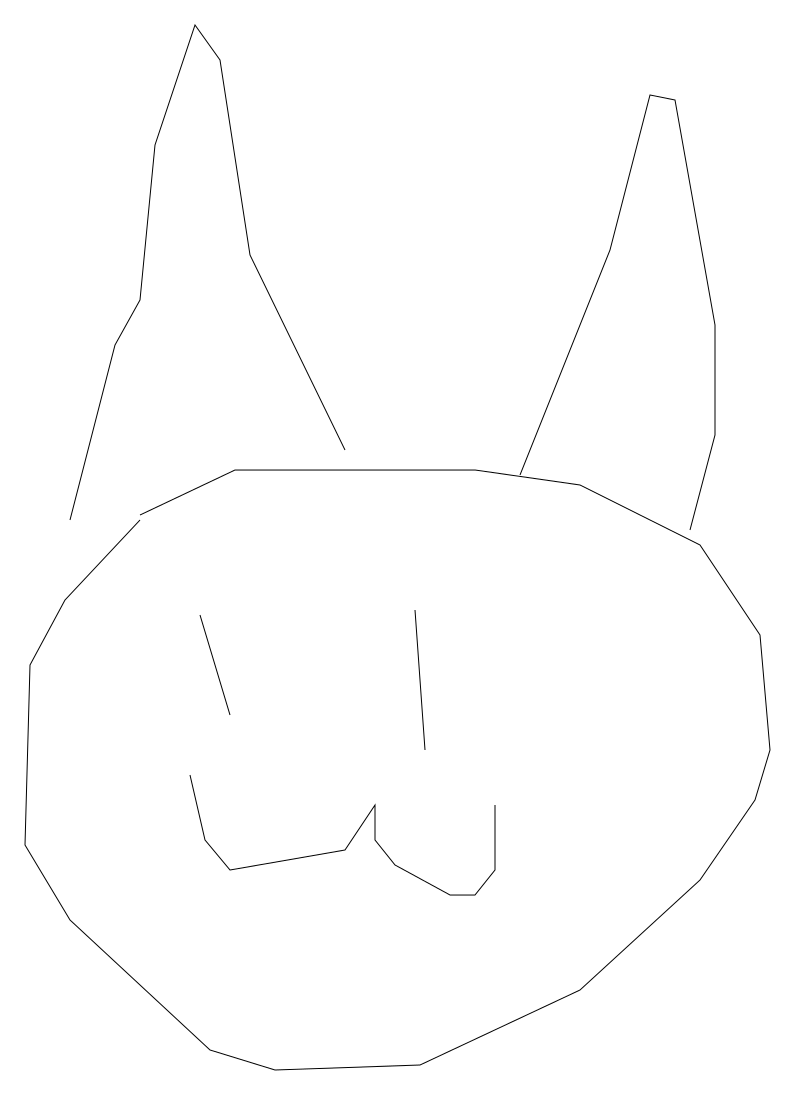

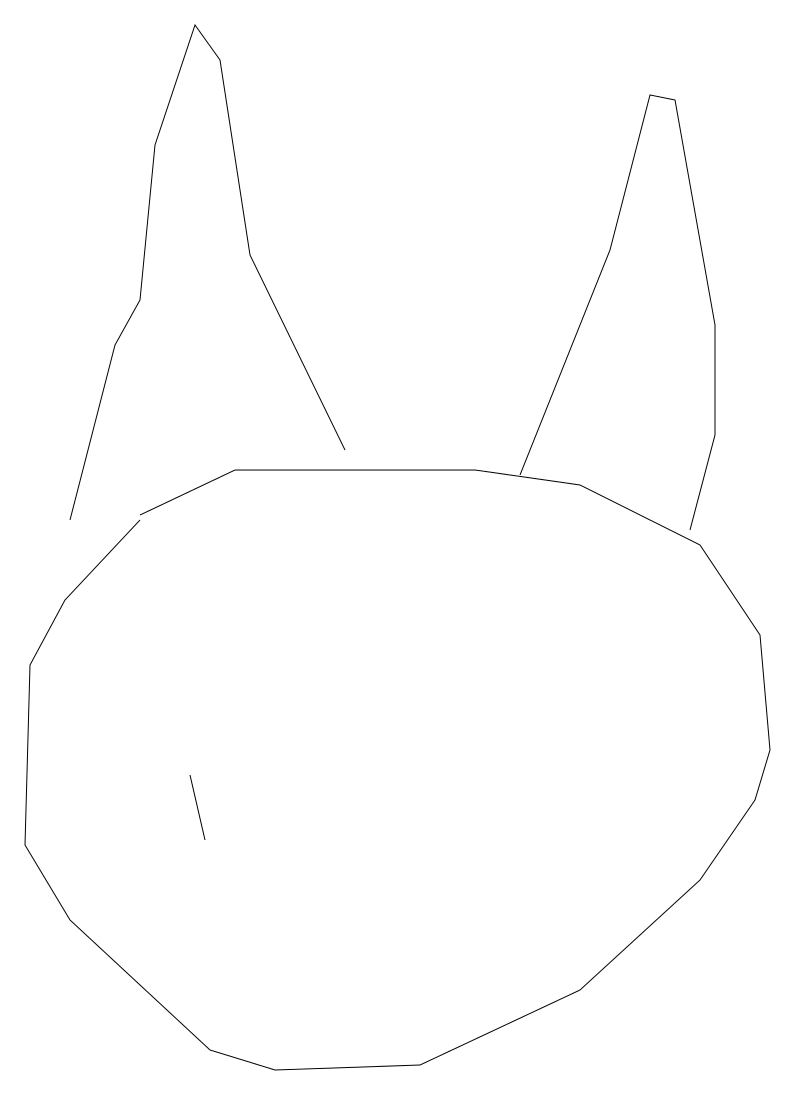

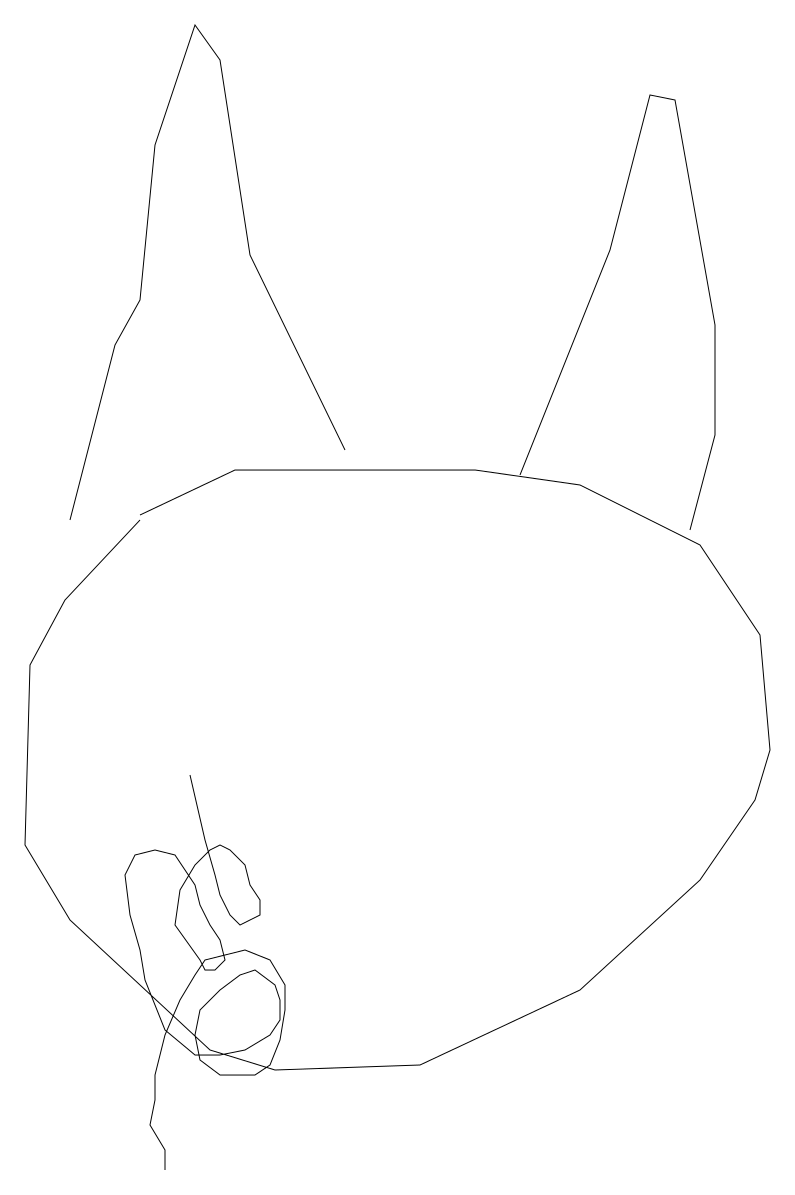

In [18]:
### this is our test file for fisplay after training
# test = data['train'][4]

def to_big_strokes(stroke, max_len=100):
    """Converts from stroke-3 to stroke-5 format and pads to given length."""
    # (But does not insert special start token).

    result = np.zeros((max_len, 5), dtype=float)
    l = len(stroke)
    assert l <= max_len
    result[0:l, 0:2] = stroke[:, 0:2]
    result[0:l, 3] = stroke[:, 2]
    result[0:l, 2] = 1 - result[0:l, 3]
    result[l:, 4] = 1
    return result

breakoff = 35

data = np.load('cat.npz', encoding='latin1', allow_pickle=True)
test = data['test'][4]
test = to_big_strokes(test)[np.newaxis, :, :]
print(test.shape)
inputs = test[:, :breakoff]
prediction = test[:, :breakoff]

while prediction[0, -1, -1] != 1 and len(prediction[0]) < 100:
    encoder_mask, combined_mask, decoder_mask = create_masks(inputs, prediction)
    output = model(
        inputs,
        prediction,
        True,
        encoder_mask,
        combined_mask,
        decoder_mask
    )[0].numpy()

    #output = np.round(output)

    offsets = np.round(output[-1, :2])

    pen_state = output[-1, 2:]
    #maxes = np.amax(pen_states, axis=1)
    pen_state = np.where(pen_state == np.amax(pen_state), 1, 0)

    output = np.concatenate((offsets, pen_state)).reshape((1, 1, 5))

    prediction = np.concatenate((prediction, output), axis=1)


for i in range(len(prediction[0])):
    if i == breakoff:
        print("Predictions begin here")
    print("True: {}".format(test[0, i]))
    print("Pred: {}".format(prediction[0, i]))
    print("")

#print(maxes)

#maxes = np.amax(predictions, axis=1).reshape((99, 1))
#predictions = np.where(predictions == maxes, 1, 0)
#print(predictions)
#print(maxes)

#for row in inputs:
#    print(row)

draw_strokes(test[0], svg_filename='realcat.svg')
draw_strokes(test[0, :breakoff], svg_filename='given_points.svg')
draw_strokes(prediction[0], svg_filename="cat.svg")


# drawing dependencies

In [8]:
# libraries required for visualisation:
import os
import svgwrite
import numpy as np
import tensorflow as tf
from IPython.display import SVG, display
import PIL
from PIL import Image
import matplotlib.pyplot as plt
# import data_Manager
import math
from matplotlib import animation

# data_Manager = Data
# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)


def get_bounds(data, factor=10):
    """Return bounds of data."""
    min_x = 0
    max_x = 0
    min_y = 0
    max_y = 0

    abs_x = 0
    abs_y = 0
    for i in range(len(data)):
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        abs_x += x
        abs_y += y
        min_x = min(min_x, abs_x)
        min_y = min(min_y, abs_y)
        max_x = max(max_x, abs_x)
        max_y = max(max_y, abs_y)

    return (min_x, max_x, min_y, max_y)


def slerp(p0, p1, t):
    """Spherical interpolation."""
    omega = np.arccos(np.dot(p0 / np.linalg.norm(p0), p1 / np.linalg.norm(p1)))
    so = np.sin(omega)
    return np.sin((1.0 - t) * omega) / so * p0 + np.sin(t * omega) / so * p1


def lerp(p0, p1, t):
    """Linear interpolation."""
    return (1.0 - t) * p0 + t * p1


def to_normal_strokes(big_stroke):
    """Convert from stroke-5 format to stroke-3."""
    l = 0
    for i in range(len(big_stroke)):
        if big_stroke[i, 4] > 0:
            l = i
            break
    if l == 0:
        l = len(big_stroke)
    result = np.zeros((l, 3))
    result[:, 0:2] = big_stroke[0:l, 0:2]
    result[:, 2] = big_stroke[0:l, 3]
    return result


# little function that displays vector images and saves them to .svg
def draw_strokes(data, factor=0.2, svg_filename = '/tmp/sketch_rnn/svg/sample.svg'):
    # data = data_Manager.to_normal_strokes(data)
    data = to_normal_strokes(data)
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)
    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
    lift_pen = 1
    abs_x = 25 - min_x 
    abs_y = 25 - min_y
    p = "M%s,%s " % (abs_x, abs_y)
    command = "m"
    for i in range(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i,0])/factor
        y = float(data[i,1])/factor
        lift_pen = data[i, 2]
        p += command+str(x)+","+str(y)+" "
    the_color = "black"
    stroke_width = 1
    dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
    dwg.save()
    display(SVG(dwg.tostring()))


"""
Function for animate drawing. 
taken from 
https://colab.research.google.com/github/zaidalyafeai/Notebooks/blob/master/Strokes_QuickDraw.ipynb#scrollTo=0ABX6O4kYwYS
"""
def create_animation(drawing, fps = 30, idx = 0, lw = 5): 
  
  seq_length = 0 
  
  xmax = 0 
  ymax = 0 
  
  xmin = math.inf
  ymin = math.inf
  
  #retreive min,max and the length of the drawing  
  for k in range(0, len(drawing)):
    x = drawing[k][0]
    y = drawing[k][1]

    seq_length += len(x)
    xmax = max([max(x), xmax]) 
    ymax = max([max(y), ymax]) 
    
    xmin = min([min(x), xmin]) 
    ymin = min([min(y), ymin]) 
    
  i = 0 
  j = 0
  
  # First set up the figure, the axis, and the plot element we want to animate
  fig = plt.figure()
  ax = plt.axes(xlim=(xmax+lw, xmin-lw), ylim=(ymax+lw, ymin-lw))
  ax.set_facecolor("white")
  line, = ax.plot([], [], lw=lw)

  #remove the axis 
  ax.grid = False
  ax.set_xticks([])
  ax.set_yticks([])
  
  # initialization function: plot the background of each frame
  def init():
      line.set_data([], [])
      return line, 

  # animation function.  This is called sequentially
  def animate(frame):    
    nonlocal i, j, line
    x = drawing[i][0]
    y = drawing[i][1]
    line.set_data(x[0:j], y[0:j])
    
    if j >= len(x):
      i +=1
      j = 0 
      line, = ax.plot([], [], lw=lw)
      
    else:
      j += 1
    return line,
  
  # call the animator.  blit=True means only re-draw the parts that have changed.
  anim = animation.FuncAnimation(fig, animate, init_func=init,
                                 frames= seq_length + len(drawing), blit=True)
  plt.close()
  
  # save the animation as an mp4.  
  anim.save(f'video.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])